# Pluto Reduction Pipeline

### Start by importing necessary modules, and reading in your files.

In [1]:
# Modules
from glob import glob
from astropy.io.fits import getheader, getdata, getval
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

# Files. Yours may be organized differently than mine. Remember, (*) can be used to read all files with
# similar names. Ex: bias01.fits and bias02.fits >>> bias*.fits.
BiasList = glob('Data/bias*.fits')
DarkList = glob('Data/dark*.fits')
FlatList = glob('Data/flat*.fits')
Night1 = glob('Data/Night1/science*.fits')
Night2 = glob('Data/Night2/science*.fits')

## Create your Master Bias.

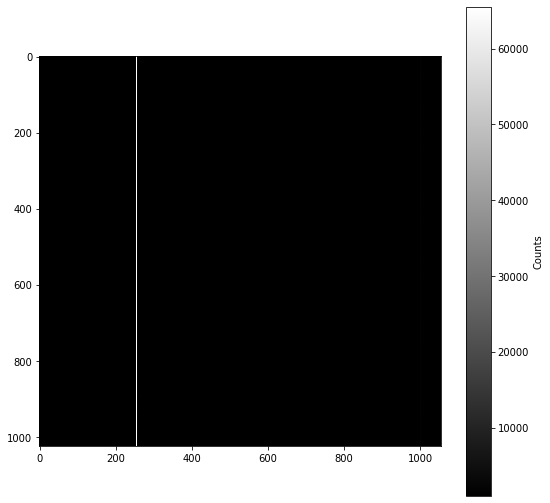

In [2]:
"""
Create your Master Bias image. I chose to create a function just to stay organized, you don't have to create
one. Master Bias image is created by stacking together all raw bias images, then dividing by the number of
bias images you are using. Finally, you can mask out any dead pixels/anomalies in the Master Bias.

Input: 
bias_list -- List of your bias images.

Output: 
Masterbias -- Your Master Bias image.
"""

def Make_Mbias(bias_list):
    
    # Create empty array of zeros equal to dimensions of a bias image.
    # 'NAXIS' 1 and 2 are image headers that refer to x/y dimensions of image.
    # getval is an astropy command that retrieves value data per pixel of image.
    Masterbias = np.zeros((getval(bias_list[1], 'NAXIS2'), getval(bias_list[1], 'NAXIS1')))
    
    # For loop to cycle through bias image list. Then add the counts of each pixel of each bias together.
    for i in range(len(bias_list)):
        Masterbias += getdata(bias_list[i])
    
    # Divide by the number of bias images.
    Masterbias = Masterbias/len(bias_list)
    return Masterbias

# Define the Master Bias by calling the function.
Mbias = Make_Mbias(BiasList)

# Plot your Master Bias in python.
plt.figure(figsize = (9,9))
plt.imshow((Mbias), cmap='gray', interpolation='nearest') # 'nearest' allows you to set the figure size
cbar = plt.colorbar()
cbar.set_label('Counts')

### This Master Bias should look funky when plotted. This is because we have not yet masked out the dead pixels/ anomalies. Look at the colorbar, which displays the number of counts. Notice the extreme difference in count levels. Next, we will mask out any weird pixels.

1055.3531117294774


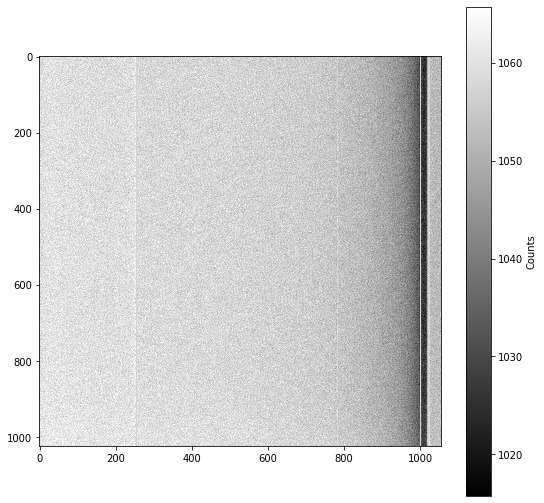

In [3]:
# Masking out anomolies/dead pixels in the image. This sets any pixels with counts in the 98.9999 percentile
# to the about average count values of 1057.
Mbias[Mbias >= np.percentile(Mbias, 98.9999)] = 1057

# Check to see if your Master Bias image has sensible counts by taking the average. Average should be between
# ~1000 to ~1100.
print(np.mean(Mbias))

# Plot your Master Bias in python.
plt.figure(figsize = (9,9))
plt.imshow((Mbias), cmap='gray', interpolation='nearest') # 'nearest' allows you to set the figure size
cbar = plt.colorbar()
cbar.set_label('Counts')

In [4]:
# If you are happy with your Master Bias, you can save it as a fits file to interact with in ds9. This will
# save the fits file in the same directory your pipeline script is in.
hduBIAS = fits.PrimaryHDU(Mbias) # <<< Set name in parenthesis to the name of your Master Bias.
hdulBIAS = fits.HDUList([hduBIAS])
NewFitsName = 'MASTERBIAS.fits'
hdulBIAS.writeto(NewFitsName, overwrite=True)

## Create your Master Flat.

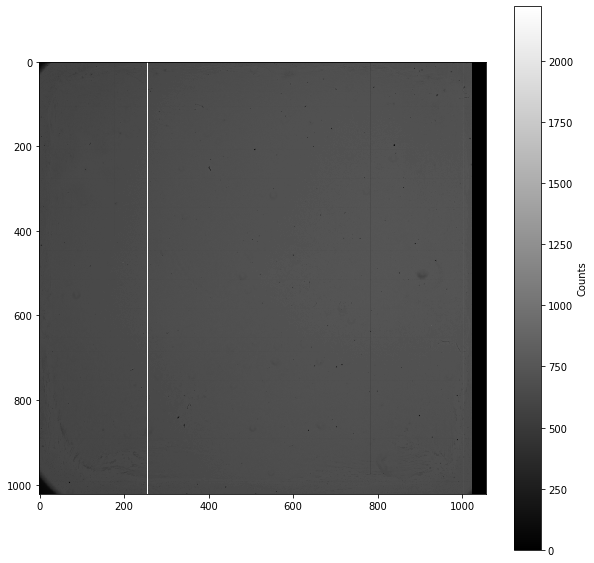

In [5]:
"""
Create your Master Flat image. I chose to use a function again for this task. To create the Master Flat,
subtract the Master Bias from each raw flat image individually, then add the results together. Next, divide by
the exposure time of a raw flat image, of which they should share the same exposre time. Finally, divide again 
by the number of images in the raw flat list.

Inputs: 
flat_list -- Your list of raw flat images.
Masterbias -- The Master Bias you just created.

Outputs:
Masterflat -- The Master Flat image.
"""

def Make_Mflat(flat_list, Masterbias):
    
    # Used the same trick again to create an array of zeros the same dimension as a raw flat image.
    Masterflat = np.zeros((getval(flat_list[1], 'NAXIS2'), getval(flat_list[1], 'NAXIS1')))
    
    # For loop to cycle through the raw flat list.
    for i in range(len(flat_list)):
        
        # Subtract the Master Bias from each raw flat, then add the results together
        Masterflat += (getdata(flat_list[i]) - Masterbias)
        # Use the command getval to retrieve the exposure time from the header of a raw flat image.
        Masterflat = Masterflat/getval(flat_list[1], 'Exptime')
        # Divide by the number of flat images in the flat list.
        Masterflat = Masterflat/len(flat_list)
    return Masterflat

# Call my function to define the Master Flat
Mflat = Make_Mflat(FlatList, Mbias)

# Plot your Master Flat
plt.figure(figsize = (10,10))
plt.imshow((Mflat), cmap='gray', interpolation='nearest')# Save image of the Master Bias
cbar = plt.colorbar()
cbar.set_label('Counts')


### Again, we need to mask the broken pixels in the image. I used the same method as in the Master Bias to do so. Also, unlike the Master Bias, the Master Flat needs to be normalized.

9.247750946969701e-07
0.9247750946969696


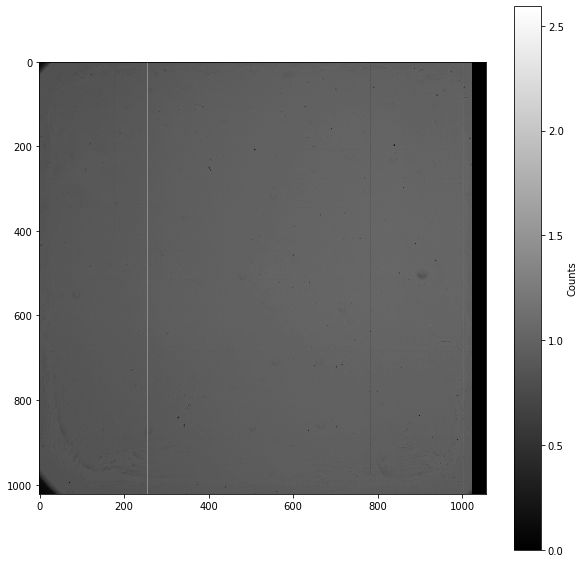

In [6]:
# Mask out pixels we don't want. I set them to 1000 since we are going to normalize anyways.
Mflat[Mflat >= np.percentile(Mflat, 99.9)] = 1000

# Normalize the Master Flat by dividing the image by the sum of the counts of all of its pixels.
Mflat = Mflat/np.sum(Mflat)
# Notice the mean is extremely small.
print(np.mean(Mflat))

# To fix this, simply multiply by the magnitude which will change the mean to ~0.9.
Mflat = Mflat* 1e6
# Now my mean is ~0.9.
print(np.mean(Mflat))

# Plot your Master Flat. Sometimes your plot may break through replotting too many times. Fix this by
# rerunning the code to create your Master Flat above, then run this box again.
plt.figure(figsize = (10,10))
plt.imshow((Mflat), cmap='gray', interpolation='nearest')# Save image of the Master Bias
cbar = plt.colorbar()
cbar.set_label('Counts')

# Save your Master Flat if you choose to.
hduFLAT = fits.PrimaryHDU(Mflat)
hdulFLAT = fits.HDUList([hduFLAT])
NewFitsName = 'MASTERFLAT.fits'
hdulFLAT.writeto(NewFitsName, overwrite=True)

## Create your science images.
### Tip: You are not creating a "Master Science." This task is meant to reduce every science image individually. So make sure your directories are organized!

In [7]:
"""
Create your science images. I used a function again. This allows me to keep my directories organized. The
science images are reduced by taking each science image individually and subtracting the Master Bias and dark
current from the counts, then dividing the result by the Masterflat. I used the published value of 0.5 for my
dark current.

Inputs:
sci_list -- Your list of raw science images.
Masterbias -- The Master Bias image you created earlier.
Masterflat -- The Master Flat image you created earlier.
directory -- Name of directory I want to store my reduced science images in. Enter as a string.

Outputs:
Writes each reduced science image as a .fits file in the specified directory.
"""

def Make_Sci(sci_list, Masterbias, Masterflat, directory):
    
    # For loop to cycle through my science list.
    for i in range(len(sci_list)):
        
        # Take the individual science images and subtract the Master Bias and dark current, then divide by the
        # Master Flat.
        final = (getdata(sci_list[i]) - Masterbias - 0.5)/(Masterflat)
        
        # Save each reduced science image individually.
        hduS = fits.PrimaryHDU(final)
        hdulS = fits.HDUList([hduS])
        
        # How to save individual reduced science images so that we can tell them apart through their names.
        hdulS.writeto('Data/'+directory+'/FinSci_'+str(i)+'.fits', overwrite=True)

/home/zepol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/home/zepol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


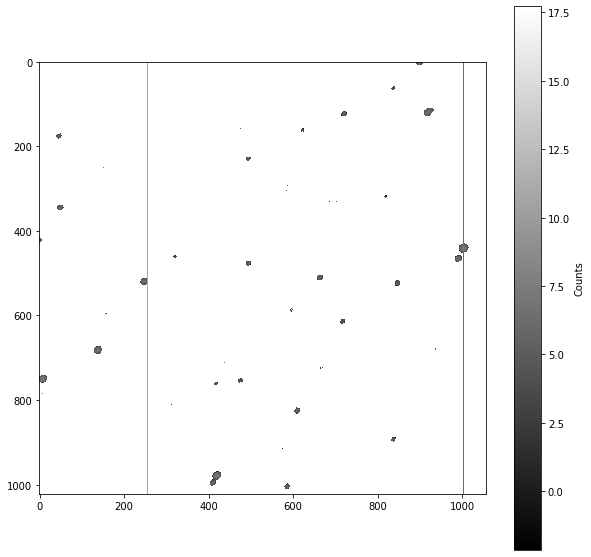

In [8]:
# Call the function twice so that the reduced science images are created in the respective directories.
Make_Sci(Night1, Mbias, Mflat, 'Night1')
Make_Sci(Night2, Mbias, Mflat, 'Night2')

# Read in the reduced science images so we can plot them.
Red_sci1 = glob('Data/Night1/FinSci*.fits')
Red_sci2 = glob('Data/Night2/FinSci*.fits')

# Plot a random reduced science image!
plt.figure(figsize = (10,10))
plt.imshow(np.log(getdata(Red_sci1[2])), cmap='gray', interpolation='nearest')# Save image of the Master Bias
cbar = plt.colorbar()
cbar.set_label('Counts')

### Now you have reduced your science images. They may look odd here but they will look better in ds9. If you open one of these images in ds9 it will initially look like a solid gray square. This is because the scale parameters are wonky. If you hover your mouse over the image, you should see the counts at around ~ -200. To fix this, click on "Scale" at  the top of the window, and select "Scale Parameters" at the very bottom of the tab that opens. A small window should pop up with a graph. Try setting the "Low" to something just under your average count value, like -300. Set the "High" to something like 500. Feel free to test values until you find something suitable to your images. Then click apply. Now you should be able to see your image more clearly. Notice how compared to the raw science images, the background noisy fuzz has been removed!

## Bonus: For the data we used for the Pluto Project, the dark images turned out to be irrelevant, so there was no need to create a Master Dark. Normally, a Master Dark is also involved in the reduction process. This will show you how to create a Master Dark.

/home/zepol/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


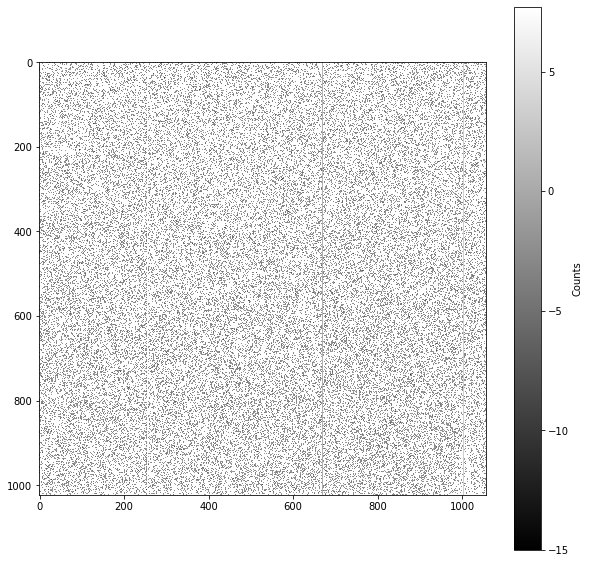

In [9]:
"""
Create a Master Dark. To do this, subtract the Master Bias from each dark image individually, then add the
results all together. Finally, divide by the exposure time of a raw dark image. These images should all have
the same exposure time.
"""
def Make_Mdark(dark_list, Masterbias):
    Masterdark = np.zeros((getval(dark_list[1], 'NAXIS2'), getval(dark_list[1], 'NAXIS1')))
    for i in range(len(dark_list)):
        Masterdark += (getdata(dark_list[i]) - Masterbias)
        Masterdark = Masterdark/getval(dark_list[i], 'Exptime')
    return Masterdark

# Call function to create the Master Dark.
Mdark = Make_Mdark(DarkList, Mbias)

# Plot the Master Dark. Take the log of your Master Dark using np.log() to make it easier to see. 
plt.figure(figsize = (10,10))
plt.imshow(np.log(Mdark), cmap='gray', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Counts')

# Save your Master Dark as a .fits file.
hduDARK = fits.PrimaryHDU(Mdark)
hdulDARK = fits.HDUList([hduDARK])
NewFitsName = 'MASTERDARK.fits'
hdulDARK.writeto(NewFitsName, overwrite=True)